<a href="https://colab.research.google.com/github/sandushiw98/Enhancing-Human-Emotion-Detection-in-Audio-Data-with-Deep-Neural-Networks-Using-Cross-Dataset/blob/main/Emotion_Recognition_using_Audio_Data_Group_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Mounting the Resource location through Google Drive
from google.colab import drive
import os

drive.mount('/content/drive')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Combine both REVDASS and TESS Dataset and Augmentation

!pip install joblib

import os
import shutil
import random

# Configuration paths
TRAINING_FILES_PATH = '/content/drive/MyDrive/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/features'
TESS_ORIGINAL_FOLDER_PATH = '/content/drive/MyDrive/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/TESS_Toronto_emotional_speech_set_data'

class TESSPipeline:

    @staticmethod
    def create_tess_folders(path):
        """
        Create and fill folders Actor_25 if YAF and Actor_26 if OAF.
        Files will be copied and renamed, not moved, to avoid messing up
        during the development of the pipeline.
        Actor_25 and Actor_26 folders must be created before running this script.
        Example filename: 03-01-07-02-02-01-01.wav
        """
        label_conversion = {
            '01': 'neutral',
            '03': 'happy',
            '04': 'sad',
            '05': 'angry',
            '06': 'fear',
            '07': 'disgust',
            '08': 'ps'  # pleasant surprise
        }

        for subdir, _, files in os.walk(path):
            for filename in files:
                try:
                    if filename.startswith('OAF'):
                        destination_path = os.path.join(TRAINING_FILES_PATH, 'Actor_26')
                    else:
                        destination_path = os.path.join(TRAINING_FILES_PATH, 'Actor_25')

                    old_file_path = os.path.join(subdir, filename)
                    base, extension = os.path.splitext(filename)

                    for key, value in label_conversion.items():
                        if base.endswith(value):
                            random_list = random.sample(range(10, 99), 7)
                            file_name = '-'.join(map(str, random_list))
                            file_name_with_correct_emotion = file_name[:6] + key + file_name[8:] + extension
                            new_file_path = os.path.join(destination_path, file_name_with_correct_emotion)

                            # Ensure destination directory exists
                            os.makedirs(destination_path, exist_ok=True)
                            shutil.copy(old_file_path, new_file_path)
                            break  # Move to the next file after finding the correct emotion
                except Exception as e:
                    print(f"Error processing file {filename}: {e}")

    @staticmethod
    def create_calm_folders(path):

        actor_27_path = os.path.join(TRAINING_FILES_PATH, 'Actor_27')
        os.makedirs(actor_27_path, exist_ok=True)

        for subdir, dirs, files in os.walk(path):
            for filename in files:
                parts = filename.split('-')  # Split the filename into parts
                if len(parts) >= 3 and parts[2] == '02':  # Check if the third part is '02'
                    full_file_path = os.path.join(subdir, filename)  # Construct the full file path

                    # First copy with the original filename
                    destination_file_path_1 = os.path.join(actor_27_path, filename)

                    # Ensure source and destination are not the same
                    if full_file_path != destination_file_path_1:
                        shutil.copy(full_file_path, destination_file_path_1)

                    # Modify the first number from '03' to '04' for the second copy
                    parts[0] = '04'
                    modified_filename = '-'.join(parts)
                    destination_file_path_2 = os.path.join(actor_27_path, modified_filename)

                    # Ensure source and destination are not the same
                    if full_file_path != destination_file_path_2:
                        shutil.copy(full_file_path, destination_file_path_2)

if __name__ == '__main__':
    TESSPipeline.create_tess_folders(TESS_ORIGINAL_FOLDER_PATH)
    TESSPipeline.create_calm_folders(TRAINING_FILES_PATH)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
#Extract feature from audio file using MFCC

!pip install joblib librosa resampy

import os
import time
import joblib
import librosa
import numpy as np
import resampy

# Configuration paths
SAVE_DIR_PATH = '/content/drive/MyDrive/NN Research/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/joblib_features'
TRAINING_FILES_PATH = '/content/drive/MyDrive/NN Research/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/features'

class CreateFeatures:

    @staticmethod
    def features_creator(path, save_dir) -> str:
        """
        This function creates the dataset and saves both data and labels in
        two files, X.joblib and y.joblib in the joblib_features folder.
        With this method, you can persist your features and train quickly
        new machine learning models instead of reloading the features
        every time with this pipeline.
        """

        lst = []

        start_time = time.time()

        for subdir, dirs, files in os.walk(path):
            for file in files:
                try:
                    # Load librosa array, obtain mfcss, store the file and the mcss information in a new array
                    X, sample_rate = librosa.load(os.path.join(subdir, file), res_type='kaiser_fast')
                    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
                    # The instruction below converts the labels (from 1 to 8) to a series from 0 to 7
                    # This is because our predictor needs to start from 0 otherwise it will try to predict also 0.
                    file_label = int(file[7:8]) - 1
                    arr = mfccs, file_label
                    lst.append(arr)
                # If the file is not valid, skip it
                except ValueError as err:
                    print(err)
                    continue

        print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

        # Creating X and y: zip makes a list of all the first elements, and a list of all the second elements.
        X, y = zip(*lst)

        # Array conversion
        X, y = np.asarray(X), np.asarray(y)

        # Array shape check
        print(X.shape, y.shape)

        # Preparing features dump
        X_name, y_name = 'X.joblib', 'y.joblib'

        joblib.dump(X, os.path.join(save_dir, X_name))
        joblib.dump(y, os.path.join(save_dir, y_name))

        return "Completed"

if __name__ == '__main__':
    print('Routine started')
    FEATURES = CreateFeatures.features_creator(path=TRAINING_FILES_PATH, save_dir=SAVE_DIR_PATH)
    print('Routine completed.')


Routine started
--- Data loaded. Loading time: 733.5363960266113 seconds ---
(8804, 40) (8804,)
Routine completed.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training started
(5898, 40, 1) (2906, 40, 1)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 40, 64)               256       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 40, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                   

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Saved trained model at /content/drive/MyDrive/NN Research/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/model/Emotion_Voice_Detection_Model.h5 


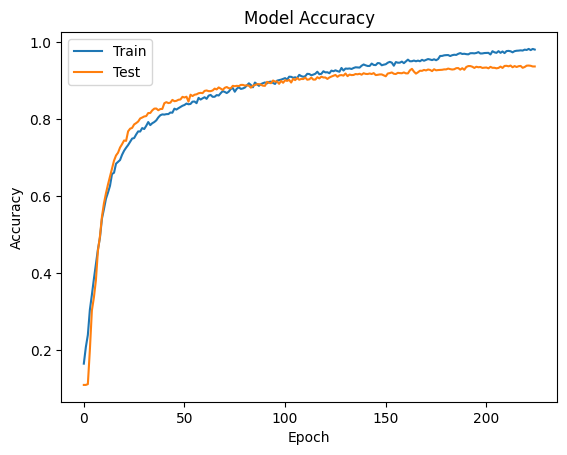

In [ ]:
#Train the Model using Neural Network and Testing

!pip install joblib librosa resampy tensorflow keras

import os
from pathlib import Path
import joblib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.layers import Dense, Conv1D, Flatten, Dropout, Activation, BatchNormalization, MaxPooling1D, Add, Input, GlobalAveragePooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Configuration paths
SAVE_DIR_PATH = '/content/drive/MyDrive/NN Research/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/joblib_features'
MODEL_DIR_PATH = '/content/drive/MyDrive/NN Research/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/model'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Set up GPU memory growth
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

class TrainModel:

    @staticmethod
    def residual_block(x, filters, kernel_size=3, stride=1):
        res = Conv1D(filters, kernel_size, padding='same', strides=stride, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        res = BatchNormalization()(res)
        res = Activation('relu')(res)
        res = Conv1D(filters, kernel_size, padding='same', strides=stride, kernel_regularizer=tf.keras.regularizers.l2(0.001))(res)
        res = BatchNormalization()(res)

        if x.shape[-1] != filters:
            x = Conv1D(filters, kernel_size, padding='same', strides=stride, kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
            x = BatchNormalization()(x)

        x = Add()([x, res])
        x = Activation('relu')(x)
        return x

    @staticmethod
    def train_neural_network(X, y) -> None:
        """
        This function trains the neural network.
        """

        # Normalize the data
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

        x_traincnn = np.expand_dims(X_train, axis=2)
        x_testcnn = np.expand_dims(X_test, axis=2)

        print(x_traincnn.shape, x_testcnn.shape)

        input_shape = (40, 1)
        inputs = Input(shape=input_shape)

        x = Conv1D(64, 3, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.001))(inputs)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.3)(x)

        x = TrainModel.residual_block(x, 128)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.3)(x)

        x = TrainModel.residual_block(x, 256)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.4)(x)

        x = TrainModel.residual_block(x, 512)
        x = MaxPooling1D(pool_size=2)(x)
        x = Dropout(0.5)(x)

        x = GlobalAveragePooling1D()(x)
        x = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = Dropout(0.5)(x)
        x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
        x = Dropout(0.5)(x)
        outputs = Dense(8, activation='softmax')(x)

        model = Model(inputs, outputs)

        print(model.summary())

        model.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics=['accuracy'])

        # Early stopping and learning rate reduction
        early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

        cnn_history = model.fit(x_traincnn, y_train, batch_size=64, epochs=300, validation_data=(x_testcnn, y_test), callbacks=[early_stopping, reduce_lr])

        # Loss plotting
        plt.plot(cnn_history.history['loss'])
        plt.plot(cnn_history.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.savefig('loss.png')
        plt.close()

        # Accuracy plotting
        plt.plot(cnn_history.history['accuracy'])
        plt.plot(cnn_history.history['val_accuracy'])
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Test'], loc='upper left')
        plt.savefig('accuracy.png')

        predictions = np.argmax(model.predict(x_testcnn), axis=1)
        new_y_test = y_test.astype(int)
        matrix = confusion_matrix(new_y_test, predictions)

        print(classification_report(new_y_test, predictions))
        print(matrix)

        model_name = 'Emotion_Voice_Detection_Model.h5'

        # Save model and weights
        model_path = Path(MODEL_DIR_PATH) / model_name
        model_path.parent.mkdir(parents=True, exist_ok=True)
        model.save(model_path)
        print('Saved trained model at %s ' % model_path)

if __name__ == '__main__':
    print('Training started')
    X = joblib.load(Path(SAVE_DIR_PATH) / 'X.joblib')
    y = joblib.load(Path(SAVE_DIR_PATH) / 'y.joblib')
    NEURAL_NET = TrainModel.train_neural_network(X=X, y=y)


In [ ]:
#Predict the emotion from example audio files using trained model.
!pip install librosa tensorflow

import os
import librosa
import numpy as np
import tensorflow as tf

# Configuration paths
EXAMPLES_PATH = '/content/drive/MyDrive/NN Research/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/examples'
MODEL_DIR_PATH = '/content/drive/MyDrive/NN Research/emotion-classification-from-audio-files-master/emotion-classification-from-audio-files-master/model'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

class LivePredictions:
    """
    Main class of the application.
    """

    def __init__(self, file):
        """
        Init method is used to initialize the main parameters.
        """
        self.file = file
        self.path = os.path.join(MODEL_DIR_PATH, 'Emotion_Voice_Detection_Model.h5')

        if not os.path.exists(self.path):
            raise FileNotFoundError(f"Model file not found: {self.path}")

        self.loaded_model = tf.keras.models.load_model(self.path)

    def make_predictions(self):
        """
        Method to process the files and create your features.
        """
        data, sampling_rate = librosa.load(self.file, res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=40).T, axis=0)
        x = np.expand_dims(mfccs, axis=0)  # Add batch dimension
        x = np.expand_dims(x, axis=2)  # Add channel dimension

        predictions = self.loaded_model.predict(x)
        predicted_class = np.argmax(predictions, axis=1)[0]

        print(f"Prediction is: {self.convert_class_to_emotion(predicted_class)}")

    @staticmethod
    def convert_class_to_emotion(pred):
        """
        Method to convert the predictions (int) into human readable strings.
        """
        label_conversion = {
            0: 'neutral',
            1: 'calm',
            2: 'happy',
            3: 'sad',
            4: 'angry',
            5: 'fearful',
            6: 'disgust',
            7: 'surprised'
        }

        return label_conversion.get(pred, "Unknown")

if __name__ == '__main__':
    example_file_1 = os.path.join(EXAMPLES_PATH, '03-02-02-02-01-02-05.wav')
    example_file_2 = os.path.join(EXAMPLES_PATH, '03-02-05-02-02-01-01.wav')
    example_file_3 = os.path.join(EXAMPLES_PATH, 'Happy.wav')

    live_prediction = LivePredictions(file=example_file_1)
    live_prediction.loaded_model.summary()
    live_prediction.make_predictions()

    live_prediction = LivePredictions(file=example_file_2)
    live_prediction.make_predictions()

    live_prediction = LivePredictions(file=example_file_3)
    live_prediction.make_predictions()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 40, 1)]              0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 40, 64)               256       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 40, 64)               256       ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                